# Import

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

# Keypoints using Mediapipe Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
#changing the colors of the landmarks(dots) and connections

def draw_styled_landmarks(image, results):
    
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1)
                             )
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,44,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,88,10), thickness=2, circle_radius=4)
                             ) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(120,44,240), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(120,88,180), thickness=2, circle_radius=2)
                             )
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(200,44,100), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(200,88,100), thickness=2, circle_radius=2)
                             ) 

In [11]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw Landmarks in real time
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [12]:
results

mediapipe.python.solution_base.SolutionOutputs

In [13]:
draw_landmarks(frame, results)

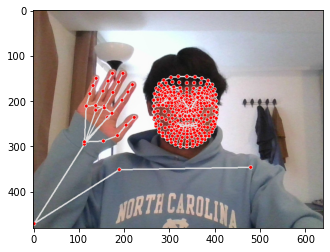

In [14]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Value

In [11]:
# we include the if else statement so that it wont get error if let say our right/left hand didnt detected
# so we basically replace them with a blank array

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3) 
    return np.concatenate([pose, face, lh, rh])

In [16]:
extract_keypoints(results)

array([ 0.54190582,  0.46230477, -1.08468747, ...,  0.21824358,
        0.31395563, -0.01934539])

In [17]:
extract_keypoints(results).shape

(1662,)

In [18]:
#checking value for the first 10 (indicate the pose value)
extract_keypoints(results)[:10]

array([ 0.54190582,  0.46230477, -1.08468747,  0.99964583,  0.56784034,
        0.40187871, -1.02154613,  0.99917108,  0.58423036,  0.40285227])

In [19]:
#chencking the value for the last 10 (indicate the Righ hand)
extract_keypoints(results)[:-10]

array([ 0.54190582,  0.46230477, -1.08468747, ..., -0.02366633,
        0.18305327,  0.44036716])

# Setup Folders For Collection

In [20]:
# Path for exported data, numpy arrays
# storing the data (data_path)
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Hello', 'Thanks', 'ILoveYou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

#creating folders for each of the data/actions

In [21]:
#making directories of each collected data

for action in actions: 
    
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# Collecting Keypoint Values for Training and Testing

In [22]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
   
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

               # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

# Preprocess Data and Create Labels and Features

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'Hello': 0, 'Thanks': 1, 'ILoveYou': 2}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        
        # like saying hey grab frame zero add it to the window
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [26]:
# to show that we have 90 videos, each has 30 frames, each one of those has 1662 keypoints

np.array(sequences).shape


(90, 30, 1662)

In [27]:
np.array(labels).shape

(90,)

In [28]:
X = np.array(sequences)

In [29]:
X.shape

(90, 30, 1662)

In [30]:
# changing our initial label to one encoded
y = to_categorical(labels).astype(int)


In [31]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [32]:
# performing a training and testing partition 
# test size would be 5% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [33]:
X_test.shape

(18, 30, 1662)

In [34]:
X_train.shape

(72, 30, 1662)

# Building and Training LSTM Neural Network

In [67]:
# allow us to perform some logging inside of tensorboard if we wanted to go and trace and monitor our model as its training

In [35]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# when using tensorflow with an lstm layer, if we're going to stack them together, 
# we need to return the sequences because the next layer is going to need those 

In [36]:
# create a log directory and set up our tensorboard callbacks

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# allow us to monitor your neural network training and our model's accuracy as it's being trained

In [37]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [45]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

Epoch 1/200
3/3 [==============================] - 4s 43ms/step - loss: 2.1948 - categorical_accuracy: 0.3333
Epoch 2/200
3/3 [==============================] - 0s 40ms/step - loss: 1.2073 - categorical_accuracy: 0.4306
Epoch 3/200
3/3 [==============================] - 0s 40ms/step - loss: 6.5845 - categorical_accuracy: 0.2639
Epoch 4/200
3/3 [==============================] - 0s 36ms/step - loss: 7.5942 - categorical_accuracy: 0.2917
Epoch 5/200
3/3 [==============================] - 0s 36ms/step - loss: 62.6422 - categorical_accuracy: 0.3333
Epoch 6/200
3/3 [==============================] - 0s 36ms/step - loss: 53.4620 - categorical_accuracy: 0.3056
Epoch 7/200
3/3 [==============================] - 0s 40ms/step - loss: 53.4015 - categorical_accuracy: 0.3750
Epoch 8/200
3/3 [==============================] - 0s 45ms/step - loss: 25.8191 - categorical_accuracy: 0.3194
Epoch 9/200
3/3 [==============================] - 0s 36ms/step - loss: 17.0336 - categorical_accuracy: 0.2778
Epoch

3/3 [==============================] - 0s 44ms/step - loss: 1.1869 - categorical_accuracy: 0.6806
Epoch 148/200
3/3 [==============================] - 0s 43ms/step - loss: 1.0547 - categorical_accuracy: 0.6806
Epoch 149/200
3/3 [==============================] - 0s 42ms/step - loss: 0.9817 - categorical_accuracy: 0.7361
Epoch 150/200
3/3 [==============================] - 0s 50ms/step - loss: 1.1681 - categorical_accuracy: 0.6250
Epoch 151/200
3/3 [==============================] - 0s 40ms/step - loss: 0.8915 - categorical_accuracy: 0.7083
Epoch 152/200
3/3 [==============================] - 0s 44ms/step - loss: 0.8663 - categorical_accuracy: 0.7778
Epoch 153/200
3/3 [==============================] - 0s 37ms/step - loss: 0.8948 - categorical_accuracy: 0.6806
Epoch 154/200
3/3 [==============================] - 0s 39ms/step - loss: 0.5469 - categorical_accuracy: 0.8611
Epoch 155/200
3/3 [==============================] - 0s 44ms/step - loss: 0.5400 - categorical_accuracy: 0.8333
Epoch 

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

# Make predictions

In [47]:
res = model.predict(X_test)

1/1 [==============================] - 0s 362ms/step


In [48]:
actions[np.argmax(res[4])]

'Hello'

In [49]:
actions[np.argmax(y_test[4])]

'Hello'

In [50]:
#save weights

model.save('action.h5')

# Evaluation Using Confusing Matrix

In [51]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [52]:
yhat = model.predict(X_train)

3/3 [==============================] - 0s 20ms/step


In [53]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [54]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[48,  2],
        [ 2, 20]],

       [[46,  2],
        [ 2, 22]],

       [[46,  0],
        [ 0, 26]]], dtype=int64)

In [55]:
accuracy_score(ytrue, yhat)

0.9444444444444444

# Test

In [9]:

model = tensorflow.keras.models.load_model('action.h5')

In [10]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Visualization logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]


            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>


NameError: name 'extract_keypoints' is not defined

In [99]:
image


array([[[245, 117,  16],
        [245, 117,  16],
        [245, 117,  16],
        ...,
        [245, 117,  16],
        [245, 117,  16],
        [245, 117,  16]],

       [[245, 117,  16],
        [245, 117,  16],
        [245, 117,  16],
        ...,
        [245, 117,  16],
        [245, 117,  16],
        [245, 117,  16]],

       [[245, 117,  16],
        [245, 117,  16],
        [245, 117,  16],
        ...,
        [245, 117,  16],
        [245, 117,  16],
        [245, 117,  16]],

       ...,

       [[ 67,  70,  68],
        [ 72,  74,  71],
        [ 69,  69,  66],
        ...,
        [ 84,  98, 107],
        [ 78,  92, 101],
        [ 79,  95, 102]],

       [[ 68,  68,  65],
        [ 74,  73,  69],
        [ 71,  67,  63],
        ...,
        [ 89,  99, 110],
        [ 81,  92, 102],
        [ 86,  98, 107]],

       [[ 65,  64,  60],
        [ 70,  68,  64],
        [ 77,  71,  66],
        ...,
        [ 90,  98, 111],
        [ 83,  92, 103],
        [ 88,  98, 108]]

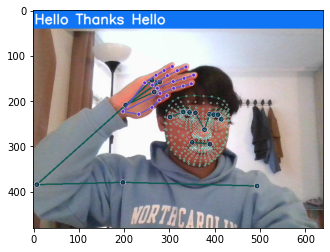

In [60]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))